# Gray-Level Co-occurance Matrix (GLCM)

A statistical method of examining texture that considers the spatial relationship of pixels is the gray-level co-occurrence matrix (GLCM). The GLCM functions characterize the texture of an image by calculating how often pairs of pixels with specific values and in a specified spatial relationship occur in an image, creating a GLCM, and then extracting statistical measures from this matrix [(MathWorks).](https://www.mathworks.com/help/images/texture-analysis-using-the-gray-level-co-occurrence-matrix-glcm.html)

This notebook explores GLCM implementation options. The selection of GLCM properties and appropriate parameters are based on the findings of the following studies, which use texture features to improve classification accuracy. In the case of cocoa agroforestry, a texture analysis can be helpful for detecting shrub crops under forest canopies and can differentiate crops such as cocoa, rubber and oil palm.
* Numbisi et al (2019)
* Abu et al (2021)
* Descals et al (2019)
* Maskell et al (2021)

In [2]:
import skimage 
from skimage.util import img_as_ubyte
from skimage import data
from skimage.feature import graycomatrix, graycoprops
import rasterio as rs
from rasterio.plot import show
import hickle as hkl
import os
import scipy
from scipy import ndimage
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import sys
import pandas as pd
from tqdm import tqdm
import numpy as np
#import cv2
from skimage import data

sys.path.append('../src/')
#from features import texture_analysis as txt
from utils import quick_viz as make
%load_ext autoreload
%autoreload 2

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Implementation Option 1 (skimage)

In [2]:
def GLCM(outRaster, sizeWindow):
    """
    Run the GLCM textures and append them into one 3D array
    The "ndimage.generic_filter" funtion perform the moving window of size "window"
    Adapted from https://github.com/JavierLopatin/Python-Remote-Sensing-Scripts/blob/master/GLCM.py
    Author: Javier Lopatin
    
    """
    # prepare textures
    def homogeneity_fun(outRaster):
        """
        create Homogeneity using the GLCM function 
        of Skimage
        """
            
        glcm = graycomatrix(outRaster, [1], [0], symmetric = True, normed = True)
        return graycoprops(glcm, 'homogeneity')[0,0]
        
    def correlation_fun(outRaster):
        """
        create Correlation using the GLCM function 
        of Skimage
        """
            
        glcm = graycomatrix(outRaster, [1], [0], symmetric = True, normed = True)
        return graycoprops(glcm, 'correlation')[0,0]
    
    def contrast_fun(outRaster):
        """
        create contrast using the GLCM function 
        of Skimage
        """
            
        glcm = graycomatrix(outRaster, [1], [0], symmetric = True, normed = True)
        return graycoprops(glcm, 'contrast')[0,0]
     
    def  dissimilarity_fun(outRaster):
        """
        create dissimilarity_fun using the GLCM function 
        of Skimage
        """
            
        glcm = graycomatrix(outRaster, [1], [0], symmetric = True, normed = True)
        return graycoprops(glcm, 'dissimilarity')[0,0]

#     outRaster = outRaster*255
#     outRaster = img_as_ubyte(outRaster)
#     if len(outRaster.shape) == 1:
#         print('Reshaping...')
#         outRaster = np.reshape(outRaster, (-1, sizeWindow))


    outRaster = outRaster.astype(np.uint8)
    assert outRaster.dtype == np.uint8, outRaster.dtype
    
    # apply to moving window
    print('Calculating variance')
    
    # np.var returns the variance of the array elements, a measure of the spread of a distribution.
    Variance = ndimage.generic_filter(outRaster, np.var, size=sizeWindow)
    print('Calculating contrast')
    Contrast = ndimage.generic_filter(outRaster, contrast_fun, size=sizeWindow)
    print('Calculating dissimilarity')
    Dissimilarity = ndimage.generic_filter(outRaster, dissimilarity_fun, size=sizeWindow)
    print('Calculating correlation')
    Correlation = ndimage.generic_filter(outRaster, correlation_fun, size=sizeWindow)
    print('Calculating homogeneity')
    Homogeneity = ndimage.generic_filter(outRaster, homogeneity_fun, size=sizeWindow)
    print('Calculating entropy')
    Entropy = ndimage.generic_filter(outRaster, entropy, size=sizeWindow)
    
    return np.dstack( (Variance, Contrast, Dissimilarity, Correlation, Homogeneity, Entropy) )

In [ ]:
# raw s2
raw_s2 = hkl.load('../data/train-s2/08154.hkl')
display(raw_s2.shape)


# apply some preprocessing steps to get in somewhat correct version
s2 = np.delete(raw_s2, -1, -1)
s2 = np.median(s2, axis = 0)
border_x = (s2.shape[0] - 14) // 2
border_y = (s2.shape[1] - 14) // 2
s2 = s2[border_x:-border_x, border_y:-border_y]
s2_slice = s2[...,1]
s2_slice = s2_slice.astype(np.uint8)
display(s2_slice.shape, s2_slice.dtype)

In [ ]:
test = GLCM(s2_slice, 5)

In [ ]:
# pull out a single piece of the function above

def contrast_fun(outRaster):
    """
    create contrast using the GLCM function 
    of Skimage
    """

    glcm = graycomatrix(outRaster, [1], [0], levels=256)
    
    return graycoprops(glcm, 'contrast')[0,0]

contrast = ndimage.generic_filter(s2_slice, contrast_fun, size=5)

## Implementation Option 2

In [18]:
## define a function to run within the moving window

def focal_variance(subarr):
    """Calcualte variance of an array
    """
    return(ndimage.variance(subarr))

# create an arr to process
arr = np.array([[1, 2, 0, 0, 5],
                [5, 3, 0, 4, 5],
                [0, 0, 0, 7, 5],
                [9, 3, 0, 0, 5],
                [9, 3, 0, 0, 5]],dtype=np.uint8)

# define the dimensions of the moving window
# creates a 5x5 array of ones
k = 5
footprint = np.ones((k,k),dtype=np.uint8)

assert arr.dtype == np.uint8
assert len(arr.shape) == 2

# apply moving window across array
ndimage.generic_filter(arr, focal_variance, footprint=footprint)

array([[ 3,  4,  5,  5,  6],
       [ 6,  7,  6,  5,  6],
       [ 9, 11,  8,  5,  6],
       [11, 13,  9,  5,  6],
       [14, 16, 11,  5,  7]], dtype=uint8)

In [31]:
footprint = np.ones((k,k),dtype=np.uint8)
footprint

array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]], dtype=uint8)

In [24]:
# raw s2
raw_s2 = hkl.load('../data/train-s2/08154.hkl')
s2 = np.delete(raw_s2, -1, -1)
s2 = np.median(s2, axis = 0)
border_x = (s2.shape[0] - 14) // 2
border_y = (s2.shape[1] - 14) // 2
s2 = s2[border_x:-border_x, border_y:-border_y]
s2_slice = s2[...,1]
s2_slice = s2_slice.astype(np.uint8)
display(s2_slice.shape, s2_slice.dtype)

(14, 14)

dtype('uint8')

In [25]:
# now try this with s2
arr = s2_slice
## define a function to run within the moving window

def focal_variance(subarr):
    """Calcualte variance of an array
    """
    return(ndimage.variance(subarr))

# define the dimensions of the moving window
# creates a 5x5 array of ones
k = 5
footprint = np.ones((k,k),dtype=np.uint8) 

assert arr.dtype == np.uint8
assert len(arr.shape) == 2

# apply moving window across array
ndimage.generic_filter(arr, focal_variance, footprint=footprint)

array([[172, 186, 186,  22,  66,  71, 202,  56,  18, 165, 156, 174,  49,
        248],
       [129,  96,  44,  71,  34, 247, 141, 192,  98, 243, 119, 252,  57,
        116],
       [111, 102, 222, 254, 137,   7, 241, 113,  97, 197, 209,  84,  39,
         73],
       [213, 216, 222, 118,  30,  87, 218,  84,  49, 171, 169,  65, 232,
        122],
       [ 24, 171, 175,  63, 162,  59, 145,  57, 193,  72,  97, 100, 134,
        160],
       [254, 132, 135,  94, 165, 209,  73,  48,  52, 241, 172,  89, 232,
         94],
       [  3, 102,   4, 174,  69,  64, 216,  10,  81,  54, 223, 139, 138,
        125],
       [ 40,  95, 136, 252,  99, 243, 154, 142, 109,   0, 211,  81, 114,
        173],
       [ 83, 233, 197, 224, 105,  50,  39, 194, 167, 140, 143,  15, 192,
        142],
       [  2,  70, 143,  62, 186, 133, 191, 120,  43, 107,   1,  96,  10,
        162],
       [ 42, 251, 171,  53,  14,  58, 115,  10,  91, 237, 140,  75,  67,
         64],
       [131, 150, 152,  13, 240, 255,  50, 

## Implementation Option 3 (np.lib.stride_tricks.sliding_window_view)

In [31]:
def glcm(img, prop):
    '''
    Properties of a GLCM. 
    
    gray-level co-occurrence matrix: a histogram of co-occurring grayscale 
    values at a given offset over an image. The 4D output array is a GLCM
    histogram: levels x levels x number of distances x number of angles.  
        - distance: indicates the distance to move (1 = 1 pixel)
        - angle: indicates which direction to move (up, down, left, right)
        - level: indicates the number of gray-level pixels counted (typically 256 for 8-bit image)
    
    gray co-props: Calculates the texture properties of a GLCM. 
    Computes a feature of a GLCM to serve as a compact summary of the matrix. 
    The properties are computed as follows: ‘contrast’, ‘dissimilarity’, 
    ‘homogeneity’, ‘energy’, ‘correlation’, ‘ASM’. 
    
    '''
    
    # define params
    dist = [1] 
    angl = [0, np.pi/4, np.pi/2, 3*np.pi/4] 
    lvl = 256 
    
    glcm = graycomatrix(img, distances=dist, angles=angl, levels=lvl)    
    glcm_props = graycoprops(glcm, prop)[0,0] # can add [0,0] to return...
    
    return glcm_props


def extract_texture(arr):
    
    '''
    Given a s2 array, calculates a 5x5 sliding window
    by moving along axis 0 and then axis 1. Calculates the GLCM property 
    for a given window of the input array (24x24).
    Removes border information and returns the concatenated 14x14 arrays
    as a single output (14, 14, num properties)
    
    '''
    # create windows - x.shape is (24, 24, 5, 5)
    windows = np.lib.stride_tricks.sliding_window_view(arr, (5,5), axis=(0,1))
    
    # hold all of the texture arrays
    properties_list = ['dissimilarity', 'correlation', 'homogeneity', 'contrast']
    texture_arr = np.zeros(shape=(14, 14, len(properties_list)))
    index = 0
    
    # for every texture property
    for prop in properties_list:
        
        output = np.zeros((windows.shape[0], windows.shape[1]))
        
        # for every item in range of 0-24
        for i, l in itertools.product(np.arange(windows.shape[0]), np.arange(windows.shape[1])):
            output[i, l] = glcm(windows[i, l, :, :], prop)
            
        # now slice out border information to get array from (24, 24) to (14, 14)
        border_x = (output.shape[0] - 14) // 2
        border_y = (output.shape[1] - 14) // 2
        cropped = output[border_x:-border_x, border_y:-border_y]
        cropped = cropped[..., np.newaxis]
        
        texture_arr[..., index:index+1] = cropped
        index += 1
    
    return texture_arr

In [37]:
def load_texture_feats(idx, directory = '../data/train-s2/'):
    
    '''
    Takes in a (28, 28, 4) s2 array and performs texture analysis
    on all four bands. Returns a () array
    '''
    
    s2 = hkl.load(directory + str(idx) + '.hkl')
    
    # remove date of imagery (last axis)
    if s2.shape[-1] == 11:
        s2 = np.delete(s2, -1, -1)
 
    # convert monthly images to annual median
    if len(s2.shape) == 4:
        s2 = np.median(s2, axis = 0)
    
    # convert to uint8 for GLCM
    s2 = s2.astype(np.uint8)
    
    blue = s2[..., 0]
    green = s2[..., 1]
    red = s2[..., 2]
    nir = s2[..., 3]
    output = np.zeros((14, 14, 16))
    
    output[..., 0:4] = extract_texture(blue)
    output[..., 4:8] = extract_texture(green)
    output[..., 8:12] = extract_texture(red)
    output[..., 12:16] = extract_texture(nir)
    
    print(output.shape)
    
    return output
                      

In [38]:
testing = load_texture_feats('15021', directory = '../data/train-s2/')

(14, 14, 16)


In [10]:
# create an 3x1 array with 257 values
x = np.full((3, 1), 1666, dtype=np.uint16)
x

array([[1666],
       [1666],
       [1666]], dtype=uint16)

In [11]:
# convert it to uint8
x.astype(np.uint8)

array([[130],
       [130],
       [130]], dtype=uint8)

In [12]:
y = ((x.astype(np.float32) / 65535) * 255).astype(np.uint8)
y

array([[6],
       [6],
       [6]], dtype=uint8)

In [ ]:
## issue is the np.astype 
s2 = hkl.load(directory + str(idx) + '.hkl')
        
# remove date of imagery (last axis)
if s2.shape[-1] == 11:
    s2 = np.delete(s2, -1, -1)

# convert monthly images to annual median
if len(s2.shape) == 4:
    s2 = np.median(s2, axis = 0)

# this has to be done after median
s2 = s2.astype(np.uint8)


In [42]:
## now apply to a sentinel tile
# test 08154
# test 15021
raw_s2 = hkl.load('../data/train-s2/15021.hkl')
s2 = np.delete(raw_s2, -1, -1)
s2 = np.median(s2, axis = 0)
s2 = s2.astype(np.uint8)

# calculate GLCM for each band in the s2 tile
band1 = extract_texture(s2[...,0]) #blue
band2 = extract_texture(s2[...,1]) #green
band3 = extract_texture(s2[...,2]) #red
band4 = extract_texture(s2[...,3]) #nir


## Implementation Option 4 (fast_glcm)

### Manual comparison using training data

In [13]:
## prepare the s2 data manually
raw_s2 = hkl.load('../data/train-s2/15021.hkl')
s2 = np.delete(raw_s2, -1, -1)
s2 = np.median(s2, axis = 0)
s2 = ((s2.astype(np.float32) / 65535) * 255).astype(np.uint8) 
red = s2[..., 2]
green = s2[..., 1]
green.shape, green.dtype

((28, 28), dtype('uint8'))

In [61]:
# slow glcm implementation
old_diss = slow.extract_texture(green, ['dissimilarity'])
old_con = slow.extract_texture(green, ['contrast'])
old_homo = slow.extract_texture(green, ['homogeneity'])
old_corr = slow.extract_texture(green, ['correlation'])

Completed 'extract_texture' in 0:00:00.253451.
Completed 'extract_texture' in 0:00:00.255773.
Completed 'extract_texture' in 0:00:00.365443.
Completed 'extract_texture' in 0:00:00.521875.


In [72]:
# fast glcm implementation w/ two level options
levels8 = 8
levels256 = 256
ks = 5
distance=1.0
angle=0
mi, ma = 0, 255


new_diss8 = fast.fast_glcm_dissimilarity(green, mi, ma, levels8, ks, distance, angle)
new_con8 = fast.fast_glcm_contrast(green, mi, ma, levels8, ks, distance, angle)
new_homo8 = fast.fast_glcm_homogeneity(green, mi, ma, levels8, ks, distance, angle)
new_corr8 = fast.fast_glcm_correlation(green, mi, ma, levels8, ks, distance, angle)

new_diss256 = fast.fast_glcm_dissimilarity(green, mi, ma, levels256, ks, distance, angle)
new_con256 = fast.fast_glcm_contrast(green, mi, ma, levels256, ks, distance, angle)
new_homo256 = fast.fast_glcm_homogeneity(green, mi, ma, levels256, ks, distance, angle)
new_corr256 = fast.fast_glcm_correlation(green, mi, ma, levels256, ks, distance, angle)

Completed 'fast_glcm_dissimilarity' in 0:00:00.003546.
Completed 'fast_glcm_contrast' in 0:00:00.002517.
Completed 'fast_glcm_homogeneity' in 0:00:00.001954.
Completed 'fast_glcm_correlation' in 0:00:00.002454.
Completed 'fast_glcm_dissimilarity' in 0:00:01.721332.
Completed 'fast_glcm_contrast' in 0:00:01.624653.
Completed 'fast_glcm_homogeneity' in 0:00:01.628787.
Completed 'fast_glcm_correlation' in 0:00:03.175555.


Per the documentation in fast_glcm.py, the `levels` parameter pertains to the number of grey-levels of GLCM, which is typically 256 for an 8-bit image. fast_glcm.py seems to use a value of 8 for this parameter. This indeed processes faster but returns erroneous results, as illustrated in the visualization of texture properties for the green band below.

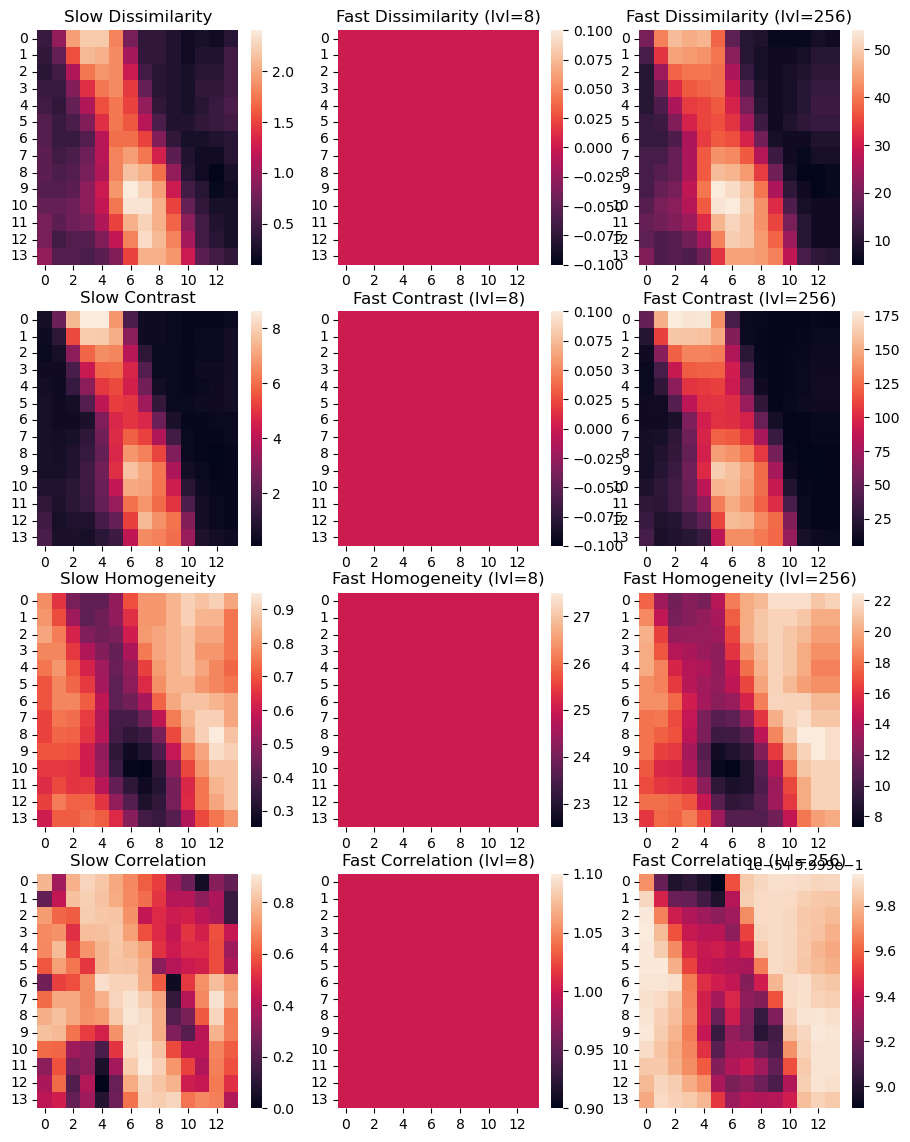

In [73]:
## GREEN BAND COMPARISON FOR TRAIN TILE 15021
plt.figure(figsize=(11, 14))

plt.subplot(4,3,1)
sns.heatmap(old_diss[...,0]).set_title('Slow Dissimilarity')
plt.subplot(4,3,2)
sns.heatmap(new_diss8[...,0]).set_title('Fast Dissimilarity (lvl=8)')
plt.subplot(4,3,3)
sns.heatmap(new_diss256[...,0]).set_title('Fast Dissimilarity (lvl=256)')

plt.subplot(4,3,4)
sns.heatmap(old_con[...,0]).set_title('Slow Contrast')
plt.subplot(4,3,5)
sns.heatmap(new_con8[...,0]).set_title('Fast Contrast (lvl=8)')
plt.subplot(4,3,6)
sns.heatmap(new_con256[...,0]).set_title('Fast Contrast (lvl=256)')

plt.subplot(4,3,7)
sns.heatmap(old_homo[...,0]).set_title('Slow Homogeneity')
plt.subplot(4,3,8)
sns.heatmap(new_homo8[...,0]).set_title('Fast Homogeneity (lvl=8)')
plt.subplot(4,3,9)
sns.heatmap(new_homo256[...,0]).set_title('Fast Homogeneity (lvl=256)')


plt.subplot(4,3,10)
sns.heatmap(old_corr[...,0]).set_title('Slow Correlation')
plt.subplot(4,3,11)
sns.heatmap(new_corr8[...,0]).set_title('Fast Correlation (lvl=8)')
plt.subplot(4,3,12)
sns.heatmap(new_corr256[...,0]).set_title('Fast Correlation (lvl=256)');

The next set of images visualizes the impact of changing the `levels` parameter for fast glcm for a larger tile in the deployment pipeline. Using the value 256 produces mo

In [91]:
# import a fast glcm texture tile created with level = 8 and level = 256
fast8 = np.load('../tmp/ghana/1648/1085/raw/feats/1648X1085Y_txt_fast8.npy')
fast256 = np.load('../tmp/ghana/1648/1085/raw/feats/1648X1085Y_txt_fast256.npy')
slow = np.load('../tmp/ghana/1648/1085/raw/feats/1648X1085Y_txtv19.npy')
fast8.shape, fast256.shape, slow.shape

((618, 614, 6), (618, 614, 6), (618, 614, 8))

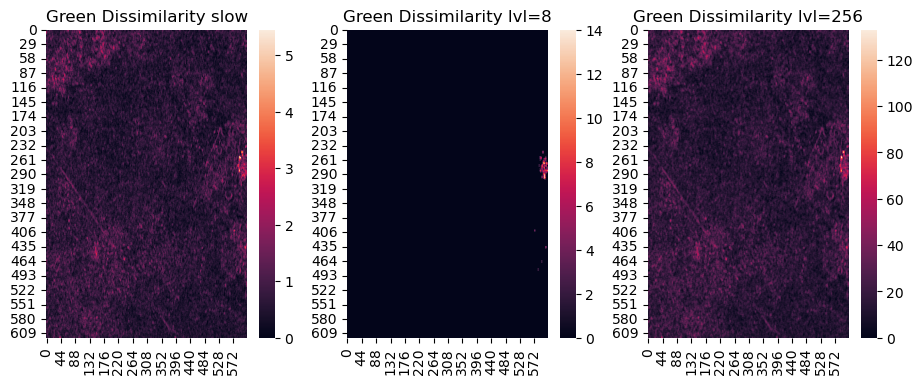

In [92]:
plt.figure(figsize=(11,4))
plt.subplot(1,3,1)
sns.heatmap(slow[...,0]).set_title('Green Dissimilarity slow')
plt.subplot(1,3,2)
sns.heatmap(fast8[...,0]).set_title('Green Dissimilarity lvl=8')
plt.subplot(1,3,3)
sns.heatmap(fast256[...,0]).set_title('Green Dissimilarity lvl=256');

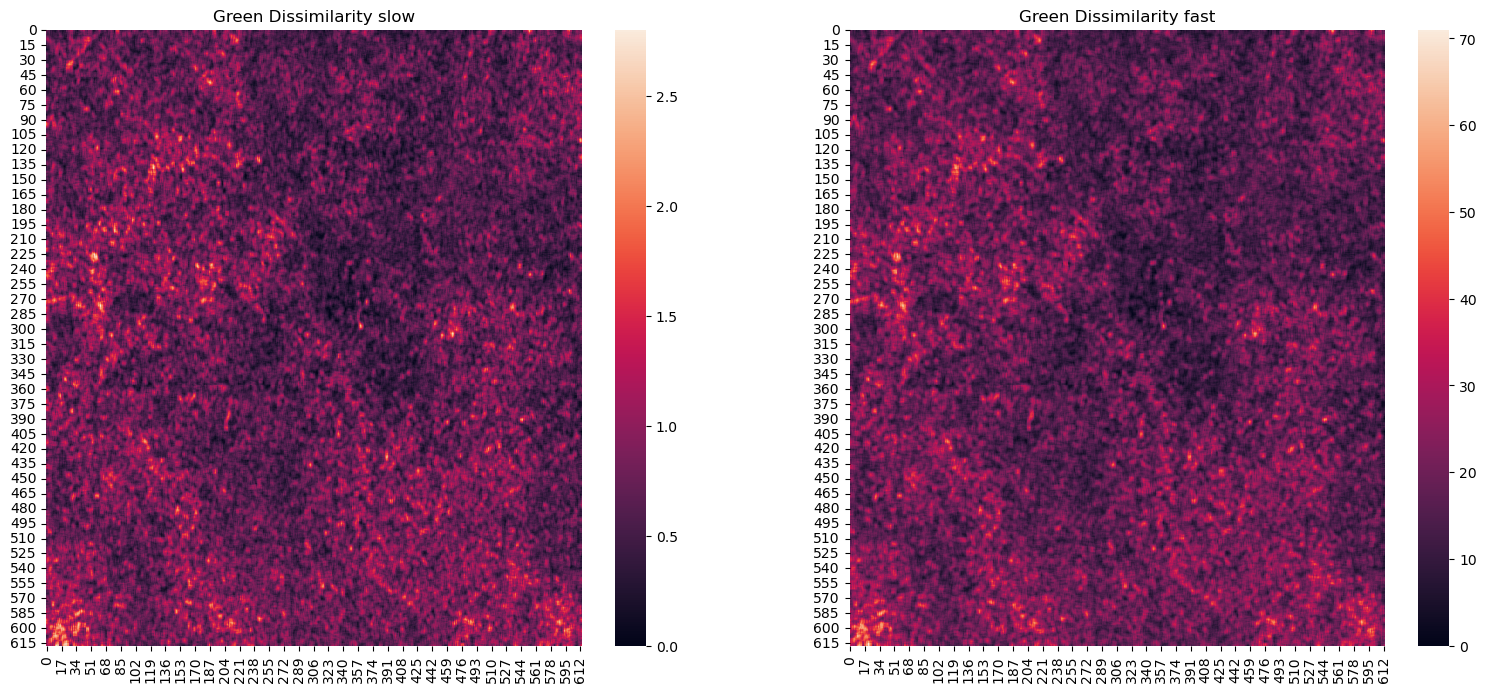

In [18]:
# now review differences between slow and optimized (fast) glcm approaches
slow = np.load('../tmp/ghana/1647/1085/raw/feats/1647X1085Y_txtv19.npy')
fast = np.load('../tmp/ghana/1647/1085/raw/feats/1647X1085Y_txt_newtest.npy')

plt.figure(figsize=(19,8))
plt.subplot(1,2,1)
sns.heatmap(slow[...,0]).set_title('Green Dissimilarity slow')
plt.subplot(1,2,2)
sns.heatmap(fast[...,0]).set_title('Green Dissimilarity fast');

In [38]:
## explore correlation diff in training pipeline
# import raw s2 tile
raw_s2 = hkl.load('../data/train-s2/15021.hkl')
s2 = np.delete(raw_s2, -1, -1)
s2 = np.median(s2, axis = 0)
s2 = ((s2.astype(np.float32) / 65535) * 255).astype(np.uint8) 

green = s2[..., 1]

# calculate correlation with slow and fast scripts
slow_corr = slow_glcm.extract_texture(green, ['correlation'])
fast_corr = fast_glcm.extract_texture(green, ['correlation'], 'train')

Finished correlation in 0.5 seconds.
Completed 'extract_texture' in 0:00:00.481376.
Completed 'fast_glcm' in 0:00:01.354793.
Completed 'extract_texture' in 0:00:03.324624.


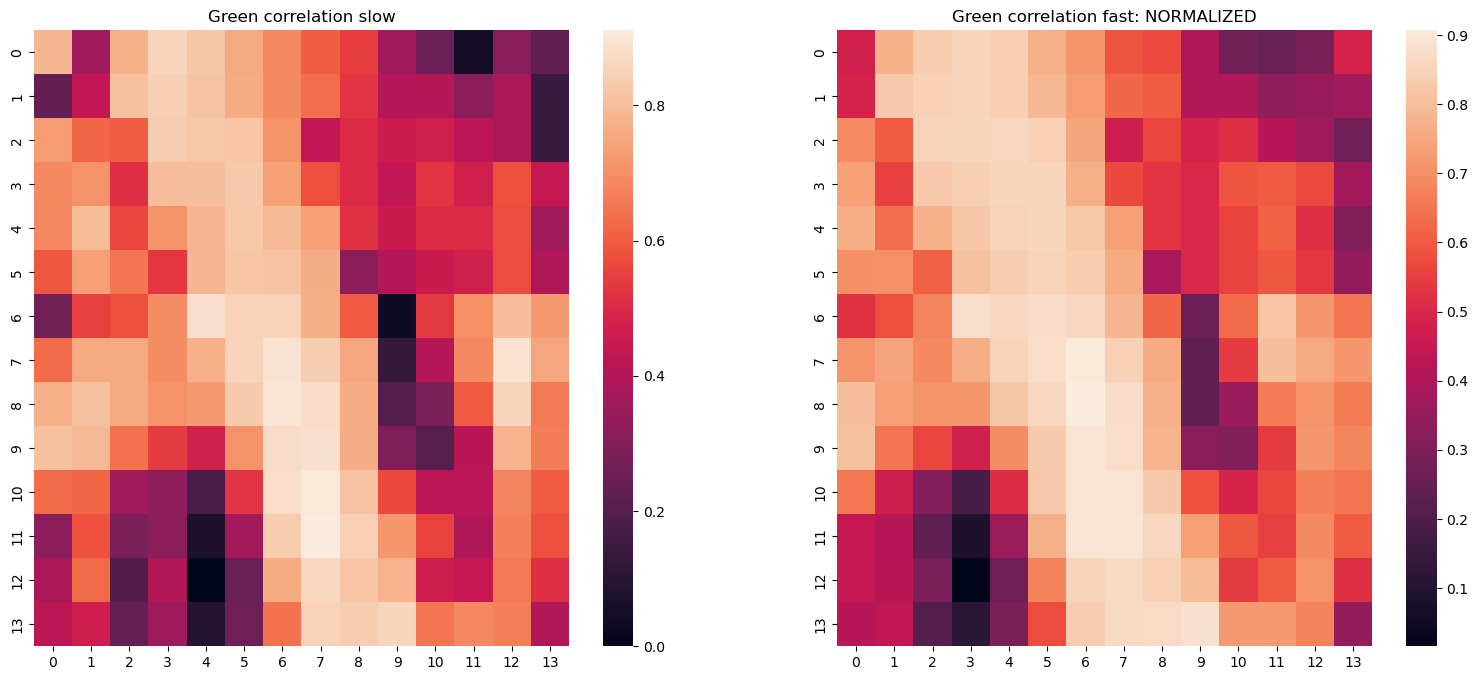

In [39]:
plt.figure(figsize=(19,8))
plt.subplot(1,2,1)
sns.heatmap(slow_corr[...,0]).set_title('Green correlation slow')
plt.subplot(1,2,2)
sns.heatmap(fast_corr[...,0]).set_title('Green correlation fast: NORMALIZED');

Finished correlation in 0.5 seconds.
Completed 'extract_texture' in 0:00:00.474086.
Completed 'fast_glcm' in 0:00:01.369400.
Completed 'extract_texture' in 0:00:03.051343.


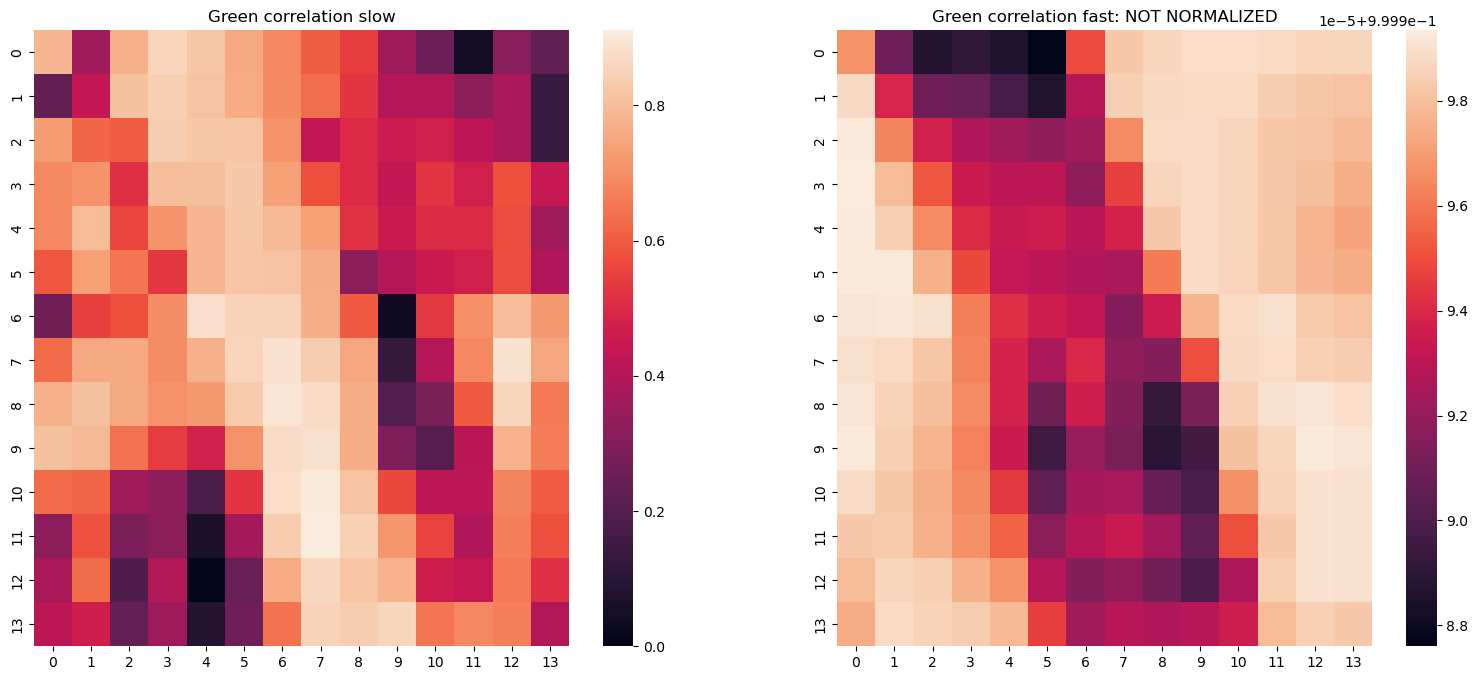

In [40]:
## explore correlation diff in training pipeline
# import raw s2 tile
raw_s2 = hkl.load('../data/train-s2/15021.hkl')
s2 = np.delete(raw_s2, -1, -1)
s2 = np.median(s2, axis = 0)
s2 = ((s2.astype(np.float32) / 65535) * 255).astype(np.uint8) 

green = s2[..., 1]

# calculate correlation with slow and fast scripts
slow_corr = slow_glcm.extract_texture(green, ['correlation'])
fast_corr = fast_glcm.extract_texture(green, ['correlation'], 'train')

plt.figure(figsize=(19,8))
plt.subplot(1,2,1)
sns.heatmap(slow_corr[...,0]).set_title('Green correlation slow')
plt.subplot(1,2,2)
sns.heatmap(fast_corr[...,0]).set_title('Green correlation fast: NOT NORMALIZED');

Finished correlation in 0.5 seconds.
Completed 'extract_texture' in 0:00:00.483778.
Completed 'fast_glcm' in 0:00:01.376877.
Completed 'fast_correlation' in 0:00:01.935816.
Completed 'extract_texture' in 0:00:03.324616.


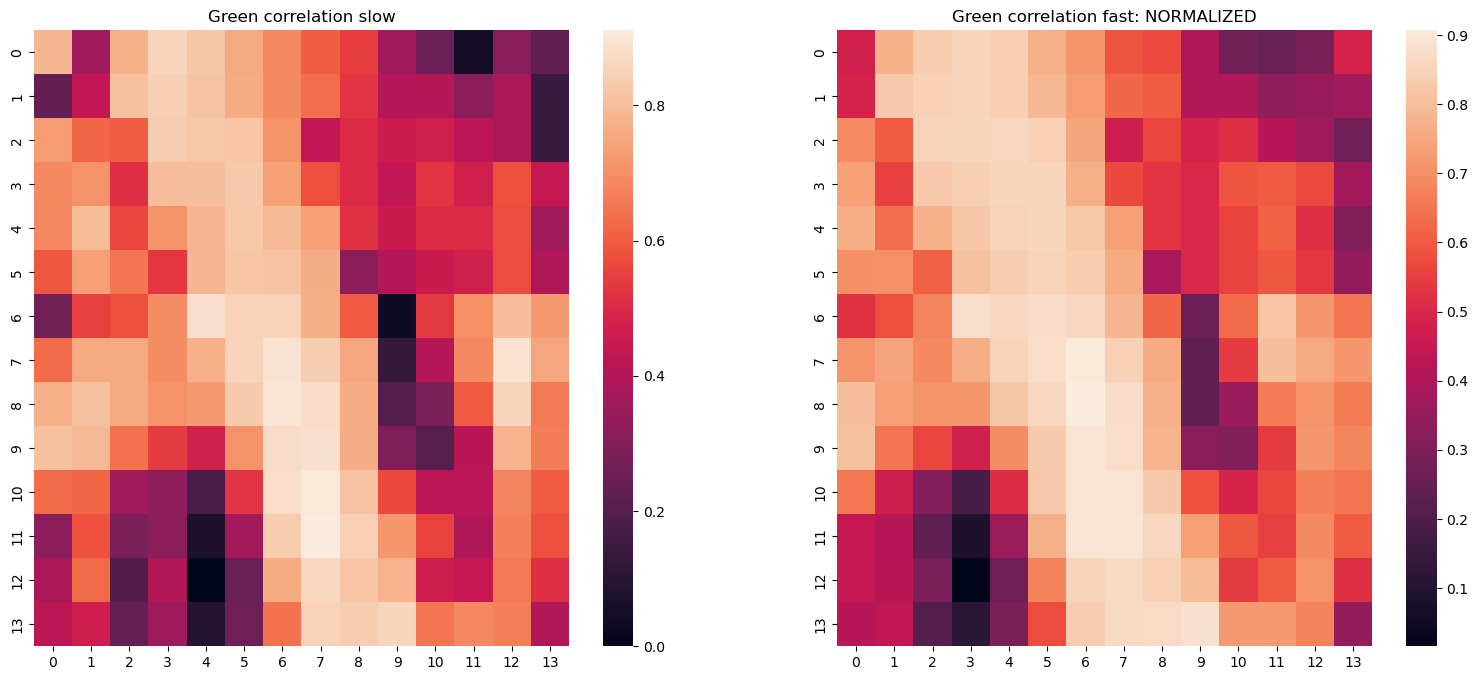

In [43]:
# once more with exactly the same code
slow_corr = slow_glcm.extract_texture(green, ['correlation'])
fast_corr = fast_glcm.extract_texture(green, ['correlation'], 'train')

plt.figure(figsize=(19,8))
plt.subplot(1,2,1)
sns.heatmap(slow_corr[...,0]).set_title('Green correlation slow')
plt.subplot(1,2,2)
sns.heatmap(fast_corr[...,0]).set_title('Green correlation fast: NORMALIZED');

In [9]:
# what are the input dims/characteristics for fast_glcm
from skimage import data
img = data.camera()
img.shape, img.dtype

((512, 512), dtype('uint8'))

In [10]:
img.min(), img.max()

(0, 255)

In [7]:
raw_s2 = hkl.load('../data/train-s2/15021.hkl')
s2 = np.delete(raw_s2, -1, -1)
s2 = np.median(s2, axis = 0)
s2 = ((s2.astype(np.float32) / 65535) * 255).astype(np.uint8)
s2[0]

array([[ 11,  18,  12, 101,  30,  88, 106, 113,  63,  33],
       [ 11,  19,  13,  99,  31,  87, 105, 110,  63,  33],
       [ 11,  19,  12, 101,  31,  87, 104, 109,  61,  32],
       [ 10,  18,  12,  99,  29,  84, 101, 106,  58,  30],
       [ 10,  18,  11,  98,  28,  84, 101, 107,  57,  29],
       [ 11,  19,  11, 102,  29,  85, 104, 110,  58,  28],
       [ 10,  18,  12, 101,  29,  85, 103, 110,  60,  29],
       [ 10,  19,  12, 100,  30,  81,  99, 105,  62,  31],
       [ 11,  18,  12,  99,  30,  79,  97, 105,  63,  33],
       [ 10,  18,  12, 101,  29,  76,  94, 102,  65,  35],
       [ 10,  17,  13,  86,  28,  62,  76,  85,  67,  40],
       [ 12,  18,  15,  71,  29,  53,  64,  72,  70,  45],
       [ 13,  18,  17,  65,  30,  52,  62,  69,  73,  49],
       [ 13,  18,  17,  63,  29,  51,  61,  68,  70,  47],
       [ 12,  16,  15,  62,  27,  51,  62,  68,  63,  41],
       [ 10,  15,  11,  69,  24,  53,  66,  74,  54,  33],
       [  8,  14,   9,  81,  21,  62,  79,  85,  49,  25

In [8]:
raw_s2 = hkl.load('../data/train-s2/15021.hkl')
s2 = np.delete(raw_s2, -1, -1)
s2 = np.median(s2, axis = 0)
s2 = ((s2 / 65535) * 255).astype(np.uint8)
s2[0]

array([[ 11,  18,  12, 101,  30,  88, 106, 113,  63,  33],
       [ 11,  19,  13,  99,  31,  87, 105, 110,  63,  33],
       [ 11,  19,  12, 101,  31,  87, 104, 109,  61,  32],
       [ 10,  18,  12,  99,  29,  84, 101, 106,  58,  30],
       [ 10,  18,  11,  98,  28,  84, 101, 107,  57,  29],
       [ 11,  19,  11, 102,  29,  85, 104, 110,  58,  28],
       [ 10,  18,  12, 101,  29,  85, 103, 110,  60,  29],
       [ 10,  19,  12, 100,  30,  81,  99, 105,  62,  31],
       [ 11,  18,  12,  99,  30,  79,  97, 105,  63,  33],
       [ 10,  18,  12, 101,  29,  76,  94, 102,  65,  35],
       [ 10,  17,  13,  86,  28,  62,  76,  85,  67,  40],
       [ 12,  18,  15,  71,  29,  53,  64,  72,  70,  45],
       [ 13,  18,  17,  65,  30,  52,  62,  69,  73,  49],
       [ 13,  18,  17,  63,  29,  51,  61,  68,  70,  47],
       [ 12,  16,  15,  62,  27,  51,  62,  68,  63,  41],
       [ 10,  15,  11,  69,  24,  53,  66,  74,  54,  33],
       [  8,  14,   9,  81,  21,  62,  79,  85,  49,  25

In [ ]:
# what steps are applied in each pipeline?

## mine
# input dims, dtype:(12, 28, 28, 11) uint16 array
# last axis (date of imagery) is removed
# convert to median
# convert to uint8
## output dims, dtype: (28, 28) uint8

# input dims, dtype: (28, 28) uint8
# graycomatrix calculation -- output is 4D array, uint32
# graycoprops calculation -- Each GLCM is normalized to have a sum of 1 before the computation

## fast glcm
# input dims, dtype: (512, 512) uint8
# glcm calculation -- Returns float32
# texture calculation --

### Debug correlation

In [52]:
vmin, vmax = 0, 255 
levels = 255
ks = 5
distance = 1.0
angle = 0.0
glcm = fast_glcm.fast_glcm(green, vmin, vmax, levels, ks, distance, angle)

Completed 'fast_glcm' in 0:00:01.351227.


In [53]:
glcm.shape, glcm.min(), glcm.max()

((255, 255, 28, 28), 0.0, 18.0)

In [54]:
P = glcm
num_level = levels

In [56]:
# normalize each GLCM
P = P.astype(np.float64)
glcm_sums = np.sum(P, axis=(0, 1), keepdims=True)
glcm_sums[glcm_sums == 0] = 1
P /= glcm_sums

P.min(), P.max()

(0.0, 0.72)

In [61]:
I, J = np.ogrid[0:num_level, 0:num_level]
I.shape, J.shape

((255, 1), (1, 255))

In [58]:
corr = np.zeros((P.shape[2], P.shape[3]), dtype=np.float32)
corr.shape

(28, 28)

In [62]:
I = np.array(range(num_level)).reshape((num_level, 1, 1, 1))
J = np.array(range(num_level)).reshape((1, num_level, 1, 1))
I.shape, J.shape

((255, 1, 1, 1), (1, 255, 1, 1))

In [63]:
diff_i = I - np.sum(I * P, axis=(0, 1))

In [65]:
diff_i.shape

(255, 1, 28, 28)

In [66]:
diff_j = J - np.sum(J * P, axis=(0, 1))
diff_j.shape

(1, 255, 28, 28)

In [68]:
std_i = np.sqrt(np.sum(P * (diff_i) ** 2, axis=(0, 1)))
std_j = np.sqrt(np.sum(P * (diff_j) ** 2, axis=(0, 1)))
std_i.shape, std_j.shape

((28, 28), (28, 28))

In [69]:
cov = np.sum(P * (diff_i * diff_j), axis=(0, 1))
cov.shape

(28, 28)

In [71]:
# handle the special case of standard deviations near zero
mask_0 = std_i < 1e-15
mask_0[std_j < 1e-15] = True
corr[mask_0] = 1

In [72]:
# handle the standard case
mask_1 = ~mask_0
corr[mask_1] = cov[mask_1] / (std_i[mask_1] * std_j[mask_1])

## Deployment pipeline (comparison)

In [79]:
x = '1671'
y = '1092'
folder = f"../tmp/ashanti/{str(x)}/{str(y)}/"
tile_str = f'{str(x)}X{str(y)}Y'
s2_10_file = f'{folder}raw/s2_10/{tile_str}.hkl'
s2_20_file = f'{folder}raw/s2_20/{tile_str}.hkl'
s2_10 = hkl.load(s2_10_file)
s2_20 = hkl.load(s2_20_file)
s2_10.shape, s2_20.shape

((10, 618, 613, 4), (10, 309, 307, 7))

In [80]:
# Ensure arrays are the same dims
width = s2_20.shape[1] * 2
height = s2_20.shape[2] * 2
width, height

(618, 614)

In [81]:
s2_10 = adjust_shape(s2_10, width, height)
s2_10.shape

(10, 618, 614, 4)

In [85]:
def process_txt_feats(s2):
    
    '''
    Takes in a (x, x, 10) s2 array and performs texture analysis
    on all four bands. Returns a () array
    '''
    s2 = img_as_ubyte(s2)
    assert s2.dtype == np.uint8, print(s2.dtype)
    
    blue = s2[..., 0]
    green = s2[..., 1]
    red = s2[..., 2]
    nir = s2[..., 3]
    output = np.zeros((14, 14, 16))
    
    output[..., 0:4] = extract_texture(blue)
    output[..., 4:8] = extract_texture(green)
    output[..., 8:12] = extract_texture(red)
    output[..., 12:16] = extract_texture(nir)
    
    print(f'texture is {output.shape}')
    
    return output

## Implementation Option 5 (fast_glcm with sliding window)

In [5]:
# create s2 

# create the glcm
vmin, vmax = 0, 255 
levels = 255
ks = 5
distance = 1.0
angle = 0.0

glcm = fast_glcm.fast_glcm(img, vmin, vmax, levels, ks, distance, angle)


NameError: name 'img' is not defined

In [ ]:
# run windowed correlation
test = fast_glcm.fast_correlation_windowed(glcm, levels)

## Visualizations

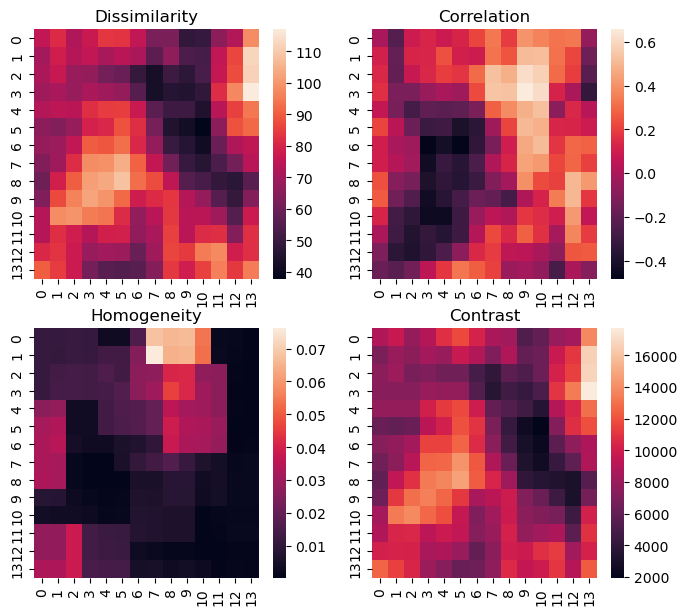

In [46]:
# not plot the results

band = band1

plt.figure(figsize=(8, 11))

plt.subplot(3,2,1)
sns.heatmap(band[...,0]).set_title('Dissimilarity')

plt.subplot(3,2,2)
sns.heatmap(band[...,1]).set_title('Correlation')

plt.subplot(3,2,3)
sns.heatmap(band[...,2]).set_title('Homogeneity')

plt.subplot(3,2,4)
sns.heatmap(band[...,3]).set_title('Contrast');

# plt.subplot(3,2,5)
# sns.heatmap(band[...,4]).set_title('ASM')

# plt.subplot(3,2,6)
# sns.heatmap(band[...,5]).set_title('Energy');

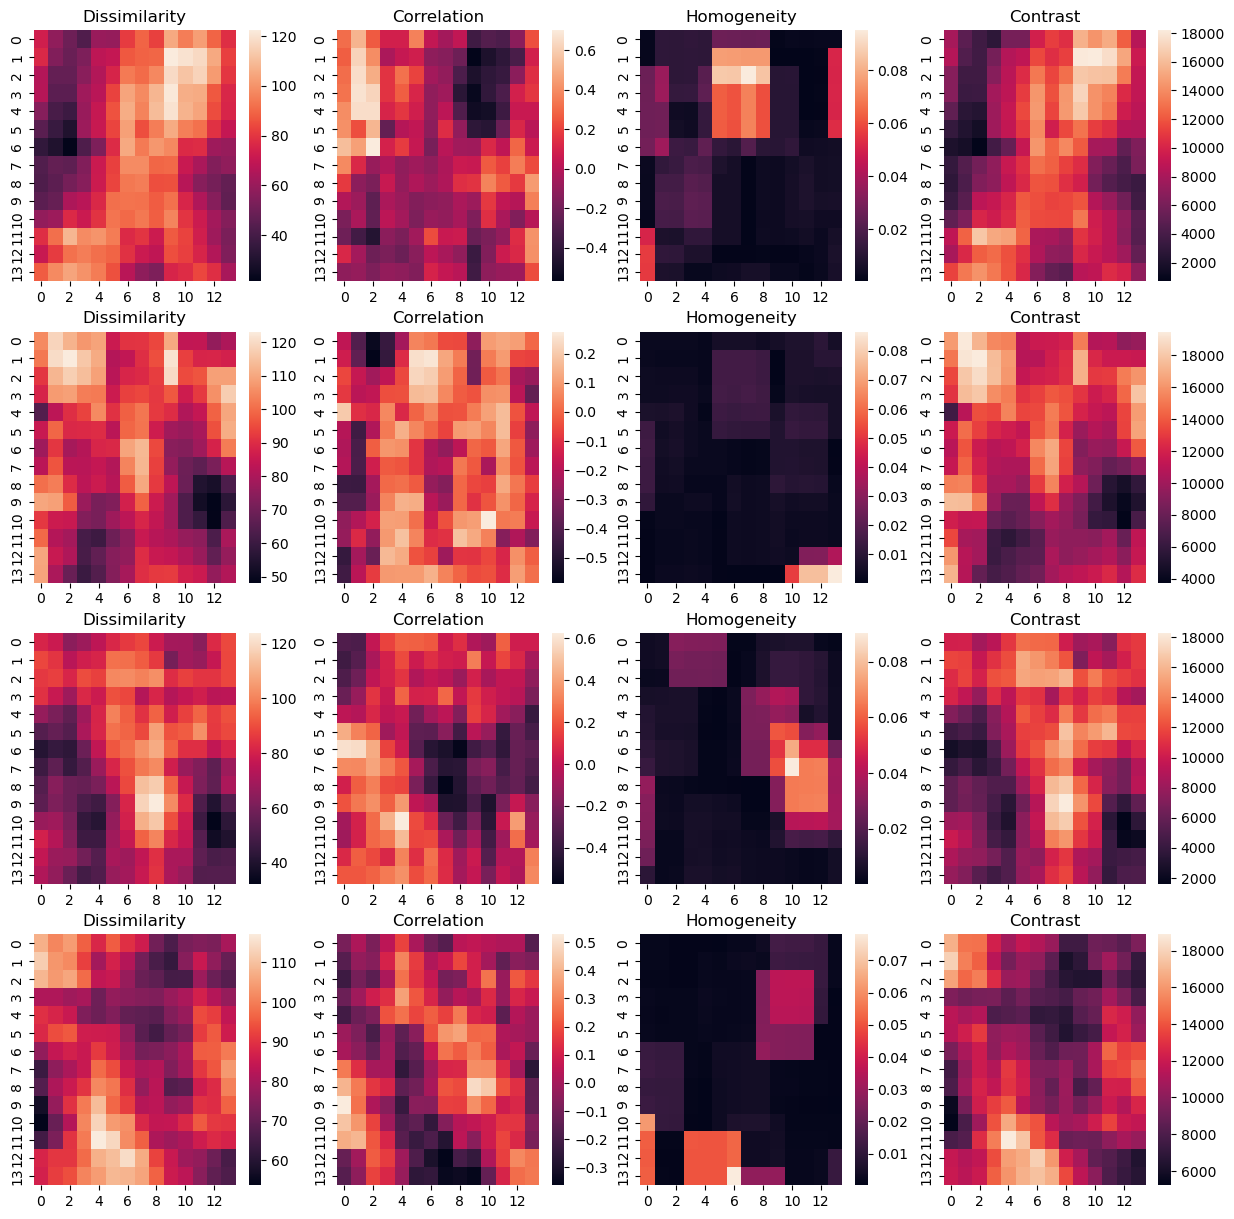

In [138]:
# ... for loop .....
arr = np.load('../data/train-texture/08002.npy')
plt.figure(figsize=(15, 15))

# blue
plt.subplot(4,4,1)
sns.heatmap(arr[...,0]).set_title('Dissimilarity')

plt.subplot(4,4,2)
sns.heatmap(arr[...,1]).set_title('Correlation')

plt.subplot(4,4,3)
sns.heatmap(arr[...,2]).set_title('Homogeneity')

plt.subplot(4,4,4)
sns.heatmap(arr[...,3]).set_title('Contrast')

# green
plt.subplot(4,4,5)
sns.heatmap(arr[...,4]).set_title('Dissimilarity')

plt.subplot(4,4,6)
sns.heatmap(arr[...,5]).set_title('Correlation')

plt.subplot(4,4,7)
sns.heatmap(arr[...,6]).set_title('Homogeneity')

plt.subplot(4,4,8)
sns.heatmap(arr[...,7]).set_title('Contrast');

# red
plt.subplot(4,4,9)
sns.heatmap(arr[...,8]).set_title('Dissimilarity')

plt.subplot(4,4,10)
sns.heatmap(arr[...,9]).set_title('Correlation')

plt.subplot(4,4,11)
sns.heatmap(arr[...,10]).set_title('Homogeneity')

plt.subplot(4,4,12)
sns.heatmap(arr[...,11]).set_title('Contrast')

# nir
plt.subplot(4,4,13)
sns.heatmap(arr[...,12]).set_title('Dissimilarity')

plt.subplot(4,4,14)
sns.heatmap(arr[...,13]).set_title('Correlation')

plt.subplot(4,4,15)
sns.heatmap(arr[...,14]).set_title('Homogeneity')

plt.subplot(4,4,16)
sns.heatmap(arr[...,15]).set_title('Contrast');

In [1]:
def multiplot(matrices, nrows = 13, ncols = 6):
    '''Docstring
    
         Parameters:
          matrices (list):
          nrows (int):
          
         Returns:
          None
    '''
    fig, axs = plt.subplots(ncols = ncols, nrows = nrows)
    fig.set_size_inches(18, 3.25*nrows)
    to_iter = [[x for x in range(i, i + ncols + 1)] for i in range(0, nrows*ncols, ncols)]
    counter = 0
    for r in range(1, nrows + 1):
        min_i = min(to_iter[r-1])
        max_i = max(to_iter[r-1])
        for i in range(ncols):
            sns.heatmap(data = matrices[..., counter], ax = axs[r - 1, i], cbar = False,
                       cmap = sns.color_palette("viridis", as_cmap=True))
            axs[r - 1, i].set_xlabel("")
            axs[r - 1, i].set_ylabel("")
            axs[r - 1, i].set_yticks([])
            axs[r - 1, i].set_xticks([])
            counter += 1
    plt.show

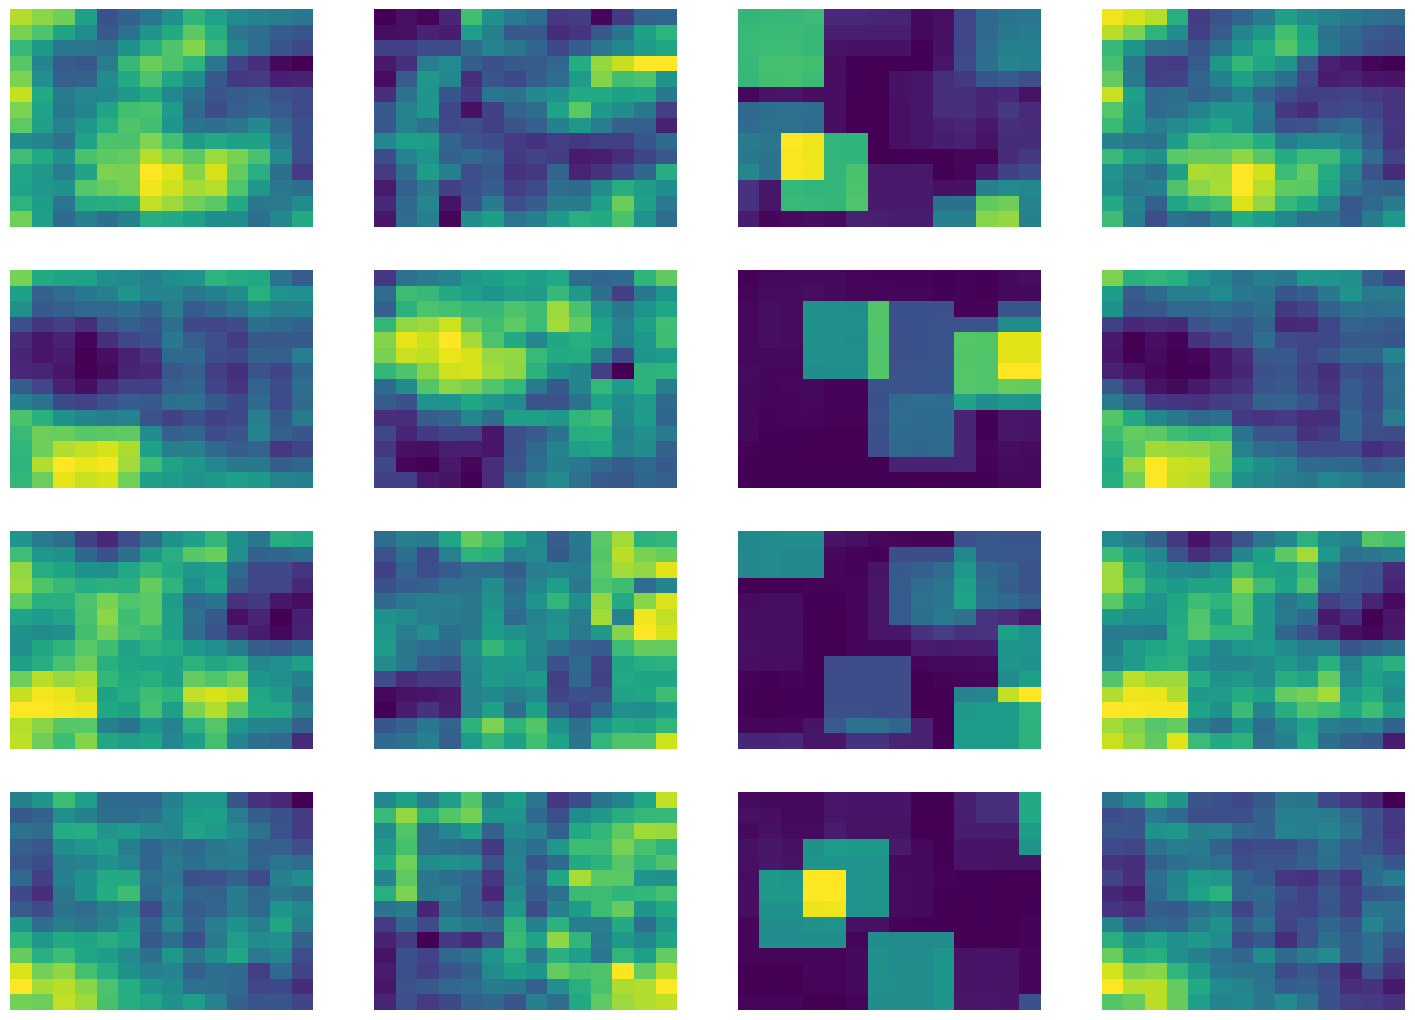

In [4]:
arr = np.load('../data/train-texture/08004.npy')
multiplot(arr, 4, 4)

(618, 610)

dtype('uint8')

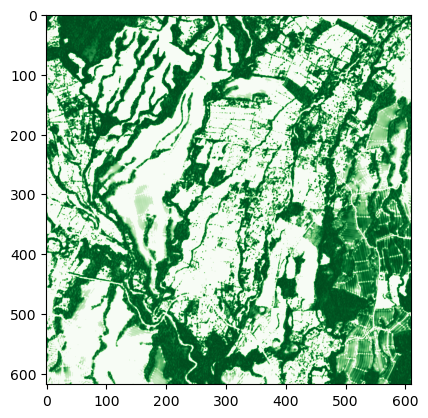

In [8]:
# select an image to work with
img = rs.open('../tmp/tml_preds/479X1129Y_FINAL.tif').read(1)
display(img.shape, img.dtype)
show(img, cmap='Greens');

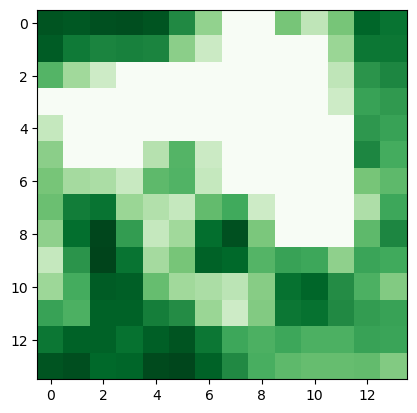

In [10]:
# this is a 14x14 plot
test = img[510:524, 510:524]
show(test, cmap='Greens');

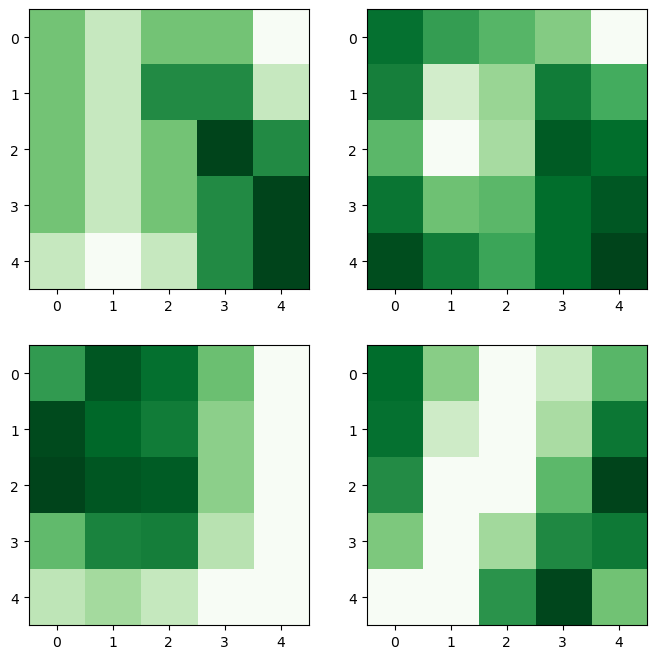

In [11]:
# select 5x5 windows
loc1 = img[500:505, 500:505]
loc2 = img[400:405, 500:505]
loc3 = img[200:205, 500:505]
loc4 = img[100:105, 500:505]
patches = [loc1, loc2, loc3, loc4]

plt.figure(figsize=(8,8))

for i, patch in enumerate(patches):
    ax = plt.subplot(2, 2, i + 1)
    show(patch, cmap='Greens', ax=ax)

## Troubleshooting

### explore issue with broken pipeline for tile

160/499 tiles processed...
Processing tile: (1654, 1157)
Traceback (most recent call last):
  File "/app/src/texture_analysis.py", line 295, in <module>
    create_txt_array(tile_idx, args.location, aak, ask)
  File "/app/src/texture_analysis.py", line 223, in create_txt_array
    s2 = img_as_ubyte(s2)
  File "/opt/conda/envs/plantations5/lib/python3.10/site-packages/skimage/util/dtype.py", line 541, in img_as_ubyte
    return _convert(image, np.uint8, force_copy)
  File "/opt/conda/envs/plantations5/lib/python3.10/site-packages/skimage/util/dtype.py", line 283, in _convert
    raise ValueError("Images of type float must be between -1 and 1.")
ValueError: Images of type float must be between -1 and 1.
ERROR conda.cli.main_run:execute(47): `conda run python3 src/texture_analysis.py --loc ghana pd_north1` failed. (See above for error)

### explore issue with shape mismatch

In [3]:
##(1655, 1069)
country = 'ghana'
x=1656
y=1069
ard = hkl.load(f'../tmp/{country}/{str(x)}/{str(y)}/ard/{str(x)}X{str(y)}Y_ard.hkl')
txt = np.load(f'../tmp/{country}/{str(x)}/{str(y)}/raw/feats/{str(x)}X{str(y)}Y_txt.npy')
feats = hkl.load(f'../tmp/{country}/{str(x)}/{str(y)}/raw/feats/{str(x)}X{str(y)}Y_feats.hkl')
ard.shape, txt.shape, feats.shape

((618, 614, 13), (614, 614, 16), (65, 614, 618))

In [31]:
# reproduce error
from skimage.util import img_as_ubyte
s2 = ard[..., 10] #8
s2.min(), s2.max()

(0.0, 0.15595827)

In [34]:
np.sum(s2 >= 1)

0

In [ ]:
plt.figure(figsize=(20,20))
binwidth = .01
min = s2.min()
max = s2.max()
band_counter = 0

for i in range(1, 11):
    plt.subplot(4,3,i)
    plt.hist(s2_a[..., band_counter].flatten(), alpha=0.5, label=str(tile_idx_a), edgecolor="black", bins=np.arange(min, max + binwidth, binwidth))
    plt.hist(s2_b[..., band_counter].flatten(), alpha=0.3, label=str(tile_idx_b), edgecolor="black", bins=np.arange(min, max + binwidth, binwidth))
    plt.xlim(0.0, 0.5)
    plt.xticks(np.arange(0.0, 0.5, 0.1))
    plt.title(title + f' Band {str(band_counter)}')
    #plt.legend();

    if tile_idx_c is not None:
        x_c, y_c = tile_idx_c[0], tile_idx_c[1]
        ard_c = hkl.load(f'../tmp/{location}/{str(x_c)}/{str(y_c)}/ard/{str(x_c)}X{str(y_c)}Y_ard.hkl')
        s2_c = ard_c[..., 0:10]
        plt.hist(s2_c[..., band_counter].flatten(), alpha=0.3, label=str(tile_idx_c), edgecolor="black", bins=np.arange(min, max + binwidth, binwidth))
    
    band_counter += 1

## Resources
* https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/
* https://github.com/catboost/tutorials/blob/master/model_analysis/shap_values_tutorial.ipynb
* https://stackoverflow.com/questions/59746304/catboost-classifier-for-class-imbalance
* https://github.com/MartimChaves/glcm_sat_img/blob/main/my_glcm/my_glcm.py
* https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_glcm.html#sphx-glr-auto-examples-features-detection-plot-glcm-py
* https://stackoverflow.com/questions/35551249/implementing-glcm-texture-feature-with-scikit-image-and-python
* https://prism.ucalgary.ca/server/api/core/bitstreams/8f9de234-cc94-401d-b701-f08ceee6cfdf/content